In [73]:
# Now say we have MNIST data in the shape of (N, 1, 28, 28)
# we will create a VAE model to generate new images similar to the training data. 

# Load MNIST data 
import torch 
import numpy as np
import torchvision

# Load MNIST data  and transform by padding to 32x32
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.Pad(2),
                                    torchvision.transforms.ToTensor()
                                ])),
    batch_size=64, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.Pad(2),
                                    torchvision.transforms.ToTensor()
                                ])),
    batch_size=64, shuffle=False)

len(train_loader), len(val_loader)

(938, 157)

In [74]:
imgs, labels = next(iter(train_loader))
imgs.shape, labels.shape

(torch.Size([64, 1, 32, 32]), torch.Size([64]))

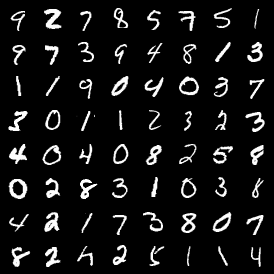

In [75]:
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(imgs, nrow=8))

In [76]:
# Encoder of a VAE is a standard convolutional neural network. 
# It takes an image as input and outputs the mean and log variance of the latent space. 
# The decoder is another convolutional neural network that takes the latent space as input and outputs an image. 
# The latent space is a continuous space that the encoder maps the input image to. 
# The decoder takes this continuous space and maps it back to an image. 
# The VAE learns to map the input image to the latent space and back to the output image in such a way that the output image is similar to the input image. 
import torch.nn as nn
class Encoder(nn.Module):
    def __init__(self, n_latent=256):
        super().__init__()
        self.encoder = nn.Sequential(
            #32x32 -> 16x16
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #16x16 -> 8x8
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #8x8 -> 4x4
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            #4x4 -> 2x2
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(256*2*2, n_latent)
        self.fc_logvar = nn.Linear(256*2*2, n_latent)
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

In [77]:
enc = Encoder()
mu, logvar = enc(imgs)
mu.shape, logvar.shape


(torch.Size([64, 256]), torch.Size([64, 256]))

In [78]:
count = 0
for p in enc.parameters():
    count += p.numel()
count


913600

In [79]:
class Decoder(nn.Module):
    def __init__(self, n_latent=256):
        super().__init__()
        self.fc = nn.Linear(n_latent, 256*2*2)
        self.decoder = nn.Sequential(
            #2x2 -> 4x4
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            #4x4 -> 8x8
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #8x8 -> 16x16
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #16x16 -> 32x32
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )
    def forward(self, z):
        z = self.fc(z)
        z = z.view(z.size(0), 256, 2, 2)
        z = self.decoder(z)
        return z


In [80]:
z = mu + torch.randn_like(mu) * torch.exp(logvar) 
print(z.shape)

torch.Size([64, 256])


In [81]:
dec = Decoder()
dec(z).shape

torch.Size([64, 1, 32, 32])

In [82]:
count = 0
for p in dec.parameters():
    count += p.numel()
count


952481

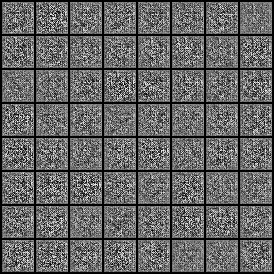

In [83]:
class VAE(nn.Module):
    def __init__(self, n_latent=128, device='mps'):
        super().__init__()
        self.n_latent = n_latent
        self.encoder = Encoder(n_latent)
        self.decoder = Decoder(n_latent)
        self.device = device    
        self.beta = 0.001 

    def forward(self, x, training=True):
        mu, logvar = self.encoder(x)
        if training:
            z = mu + (torch.randn_like(mu) * torch.exp(0.5 * logvar) * 1.2 )
        else:
            z = mu
        return self.decoder(z), mu, logvar
    
    def generate(self, n_samples):
        z = torch.randn(n_samples, self.n_latent).to(self.device)
        return self.decoder(z)
    
    def loss_function(self, recon_x, x, mu, logvar, current_epoch, max_epochs):
        #MSE = torch.nn.functional.mse_loss(recon_x, x)
        BCE = torch.nn.functional.binary_cross_entropy(recon_x, x, reduction='sum') / x.size(0)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        # Gradually increase beta from 0 to final value
        beta_final = 0.01
        self.beta = beta_final * min(current_epoch / (max_epochs * 0.2), 1.0)

        return BCE + self.beta * KLD

vae = VAE(device='mps')
vae.to(device='mps')

output, _, _ = vae(imgs.to(device='mps'), training=False)
output.shape
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(output.view(64, 1, 32, 32).detach().cpu(), nrow=8))


In [84]:
count = 0
for p in vae.parameters():
    count += p.numel()
count


1472609

In [85]:
torch.nn.functional.binary_cross_entropy(output, imgs.to(device='mps'), reduction='sum') 


tensor(47248.4922, device='mps:0', grad_fn=<BinaryCrossEntropyBackward0>)

In [86]:
epochs = 20
optimizer = torch.optim.AdamW(vae.parameters(), lr=1e-4)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)


train_loss = []
val_loss = []

#Add tqdm and all parameters to a corner progress bar
from tqdm import tqdm

for epoch in range(epochs):
    train_loss_epoch = []
    with tqdm(train_loader, total=len(train_loader), desc="Training", leave=False) as pbar:
        for i, (x, _) in enumerate(pbar):
            x = x.to(device='mps')
            recon_batch, mu, logvar = vae(x)
            loss = vae.loss_function(recon_batch, x, mu, logvar, epoch, epochs)
            #Add loss to the progress bar
            pbar.set_postfix(loss=loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss_epoch.append(loss.item())
            #scheduler.step()
    train_loss.append(np.mean(train_loss_epoch))
    
    val_loss_epoch = []
    # Add a progress bar for the validation loop and it disappears when the loop is done
    with tqdm(val_loader, total=len(val_loader), desc="Validating", leave=False) as pbar:
        for i, (x, _) in enumerate(pbar):
            x = x.to(device='mps')
            recon_batch, mu, logvar = vae(x, training=False)
            loss = vae.loss_function(recon_batch, x, mu, logvar, epoch, epochs)
            # Add loss to the progress bar 
            pbar.set_postfix(val_loss=loss.item())
            val_loss_epoch.append(loss.item())
    val_loss.append(np.mean(val_loss_epoch))

    if (epoch+1) % 2 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}')
    
    #Generate some images
    samples = vae.generate(64)
    generated_imgs = torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(samples.view(64, 1, 32, 32).detach().cpu(), nrow=8))
    generated_imgs.save(f'generated/vae_samples_{epoch+1}.png')


Epoch 2/20, Train Loss: 104.6222, Val Loss: 85.8449


Epoch 4/20, Train Loss: 102.1412, Val Loss: 88.9938


Epoch 6/20, Train Loss: 102.0445, Val Loss: 90.0761


Epoch 8/20, Train Loss: 98.8668, Val Loss: 88.0877


Epoch 10/20, Train Loss: 96.9532, Val Loss: 86.9165


Epoch 12/20, Train Loss: 95.6770, Val Loss: 86.4093


Epoch 14/20, Train Loss: 94.6157, Val Loss: 85.6622


Epoch 16/20, Train Loss: 93.8505, Val Loss: 85.5879


Epoch 18/20, Train Loss: 93.2245, Val Loss: 85.0162


Epoch 20/20, Train Loss: 92.6790, Val Loss: 84.8302


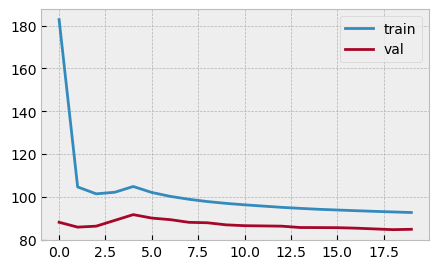

In [99]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

plt.figure(figsize=(5, 3))
plt.plot(train_loss, label='train') 
plt.plot(val_loss, label='val')
plt.legend()
plt.show()

In [94]:
mu, logvar = vae.encoder(imgs.to(device='mps'))
mu.shape, logvar.shape

(torch.Size([64, 128]), torch.Size([64, 128]))

In [100]:
mu.mean(), logvar.exp().mean()


(tensor(-0.0049, device='mps:0', grad_fn=<MeanBackward0>),
 tensor(0.8142, device='mps:0', grad_fn=<MeanBackward0>))